# Logitic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.cross_validation import cross_val_score

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
maldata=pd.read_csv('../../Data/malware.csv',sep='|')

x=maldata.drop(['Name', 'md5', 'legitimate'], axis=1).values
y=maldata['legitimate'].values
print(x.shape)


feature_select_model=ExtraTreesClassifier()
feature_select_model.fit(x,y)
model = SelectFromModel(feature_select_model, prefit=True)
x=model.transform(x)
print(x.shape)

number_of_samples=len(y)

random_indices=np.random.permutation(number_of_samples)

num_train=int(number_of_samples*0.7)
num_test=int(number_of_samples*0.30)

x_train=x[random_indices[:num_train]]
y_train=y[random_indices[:num_train]]

x_test=x[random_indices[num_train:]]
y_test=y[random_indices[num_train:]]

model=LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

(138047, 54)
(138047, 13)


## Accuracy

In [7]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

('Accuracy:', 30.056742726065433)


## Null Accuracy

In [8]:
print(max(y_test.mean(), 1 - y_test.mean())*100)

69.9432572739


## Confusion Matrix

In [10]:
print(metrics.confusion_matrix(y_test, y_pred))
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


# Accuracy
print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN)*100)

#Misclassification
print('Misclassification:',(FP+FN)/float(TP+TN+FP+FN)*100)

#Sensitivity
print('Sensitivity:',(TP)/float(TP+FN)*100)

#Specificity
print('Specificty:',(TN)/float(TN+FP)*100)

#Flase Positive Rate
print('False Positive:',(FP)/float(TN+FP)*100)

#Precision Score
print('Precision Score:', (TP)/float(TP+FP)*100)

[[    0 28967]
 [    0 12448]]
('Accuracy:', 30.056742726065433)
('Misclassification:', 69.943257273934563)
('Sensitivity:', 100.0)
('Specificty:', 0.0)
('False Positive:', 100.0)
('Precision Score:', 30.056742726065433)


## ROC-AUC

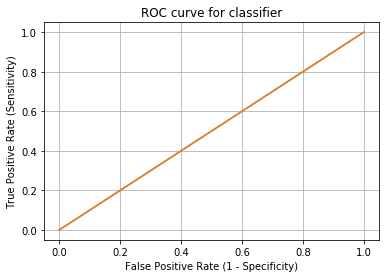

0.5
0.957088062754


In [12]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()
print(metrics.roc_auc_score(y_test, y_pred))
print(cross_val_score(model, x, y, cv=10, scoring='roc_auc').mean())

## Threshold Selection

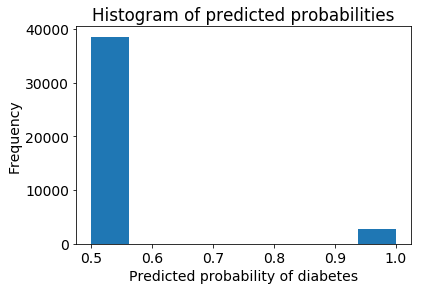

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

y_pred_prob = model.predict_proba(x_test)[:, 1]
plt.hist(y_pred_prob, bins=8)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

In [14]:
y_pred_new = binarize([y_pred_prob], 0.7)[0]
print(y_pred)
print(y_pred_new)

[1 1 1 ..., 1 1 1]
[ 0.  0.  0. ...,  0.  0.  0.]


In [15]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    
print(evaluate_threshold(0.7))

('Sensitivity:', 1.0)
('Specificity:', 0.0)
None


## Grid Search

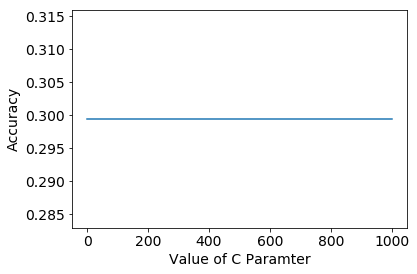

0.299340079828
{'C': 0.001}
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [17]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

model=LogisticRegression(penalty='l2')
grid=GridSearchCV(model,param_grid,cv=10,scoring='accuracy')
grid.fit(x,y)

grid_mean_scores= [result.mean_validation_score for result in grid.grid_scores_]
C=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(C,grid_mean_scores)
plt.xlabel('Value of C Paramter')
plt.ylabel('Accuracy')
plt.show()

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [19]:
model=LogisticRegression(**grid.best_params_)
model.fit(x_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_predtrain=model.predict(x_train)
print("Train Accuracy:",metrics.accuracy_score(y_train,y_predtrain)*100)

y_predtest=model.predict(x_test)
print("Test Accuracy:",metrics.accuracy_score(y_test,y_predtest)*100)

('Train Accuracy:', 29.881405745508733)
('Test Accuracy:', 30.056742726065433)


In [22]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(y_test,y_predtest)
TP=confusion[1,1]
TN=confusion[0,0]
FP=confusion[0,1]
FN=confusion[1,0]

# Accuracy
print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN)*100)

#Misclassification
print('Misclassification:',(FP+FN)/float(TP+TN+FP+FN)*100)

#Sensitivity
print('Sensitivity:',(TP)/float(TP+FN)*100)

#Specificity
print('Specificty:',(TN)/float(TN+FP)*100)

#Flase Positive Rate
print('False Positive:',(FP)/float(TN+FP)*100)

#Precision Score
print('Precision Score:', (TP)/float(TP+FP)*100)

('Accuracy:', 30.056742726065433)
('Misclassification:', 69.943257273934563)
('Sensitivity:', 100.0)
('Specificty:', 0.0)
('False Positive:', 100.0)
('Precision Score:', 30.056742726065433)


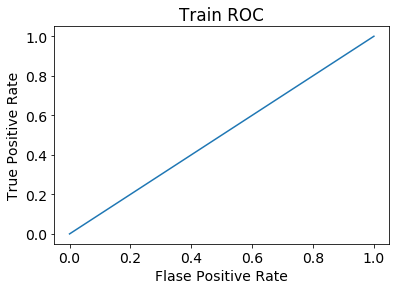

('Train AUC:', 0.5)


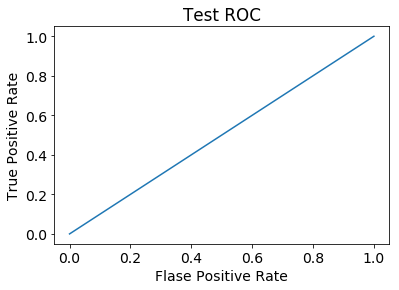

('Test AUC:', 0.5)


In [23]:
fpr,tpr,threshold=metrics.roc_curve(y_train,y_predtrain)
plt.plot(fpr,tpr)
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.show()

print("Train AUC:",metrics.roc_auc_score(y_train,y_predtrain))



fpr,tpr,threshold=metrics.roc_curve(y_test,y_predtest)
plt.plot(fpr,tpr)
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.show()

print("Test AUC:",metrics.roc_auc_score(y_test,y_predtest))